This first block of text simply contains all the libraries that need importing as well as initialising some variables of this example. You may change the batch_size and epochs variables, but should not change num_classes, img_rows and img_cols as these depend on the dataset being used

In [1]:
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow.keras.datasets as datasets
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import tensorflow.keras.applications as applications

batch_size = 256
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 32, 32

# list of CNN architectures used for comparison
architectures = ['VGG16', 'VGG19', 'ResNet50', 'ResNet152', 'ResNet50V2', 'ResNet152V2', 'DenseNet201', 'MobileNetV3Large', 'EfficientNetB0', 'EfficientNetB7']

The next block of text handles all the data loading (in this case of the CIFAR-10 dataset) and reshaping so that it can be used to train and evaluate the CNN models. Two sets of data are loaded, the training data, used to generate the model, and the test data, used to evaluate if this model is good at making predictions

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test_orig = y_test
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


This cell loads given pre-defined architecture, that had been trained for a different problem. It removes the last layer (because that would be specific to the original problem, and adds some new layers. This process of adapting a network trained on a different problem is called *Transfer Learning*.

The only essential new layer to add is the softmax one (last) that specifies the number of classes of the new dataset.

In [3]:
def get_model(architecture):
    # Use the given pre-defined CNN architecture
    cnn_model = getattr(applications, architecture)
    base_model = cnn_model(weights='imagenet', include_top=False, input_shape=input_shape)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)

    # The rest of this cell is common to both defining the full architecture or using a pre-trained one
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    return model

This is the block of code that trains models and evaluates their predictive capacity on the test data.

In [4]:
train_acc, val_acc = ([] for i in range(2))

for cnn_type in architectures:
    # Create model
    model = get_model(cnn_type)

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          verbose=1)

    # Save results
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Evaluate the model on the test data
    test_loss, test_acc =  model.evaluate(x_test, y_test,
              batch_size=batch_size,
              verbose=0)

    # Display the final accuracy and loss of the CNN architecture
    print(cnn_type, 'accuracy: %.2f%%' % (test_acc * 100), ', loss: %.2f' % test_loss)
    print()

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/20
196/196 [==============================] - 57s 106ms/step - loss: 2.3203 - accuracy: 0.1472 - val_loss: 2.0605 - val_accuracy: 0.3092
Epoch 2/20
196/196 [==============================] - 19s 97ms/step - loss: 1.8774 - accuracy: 0.3697 - val_loss: 1.4136 - val_accuracy: 0.5053
Epoch 3/20
196/196 [==============================] - 19s 98ms/step - loss: 1.3199 - accuracy: 0.5407 - val_loss: 1.1994 - val_accuracy: 0.5822
Epoch 4/20
196/196 [==============================] - 19s 97ms/step - loss: 1.1337 - accuracy: 0.6069 - val_loss: 1.0775 - val_accuracy: 0.6232
Epoch 5/20
196/196 [==============================] - 19s 96ms/step - loss: 1.0231 - accuracy: 0.6464 - val_loss: 1.0104 - val_accuracy: 0.6464
Epoch 6/20
196/196 [==============================] - 19s 96ms/step - loss: 0.9668 - accuracy: 0.6624 - val_loss: 0.9577 - val_accuracy: 0.6679
Epoch 7/20
196/196 [==============================] - 19s 97ms/step - 

Finally, plots of how the training & validation accuracy functions changes through the epochs of training is shown.

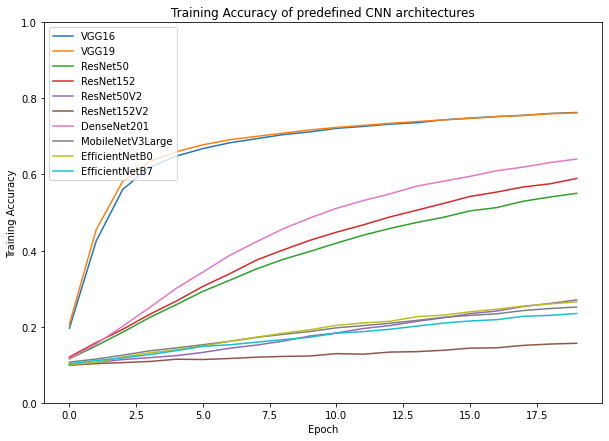

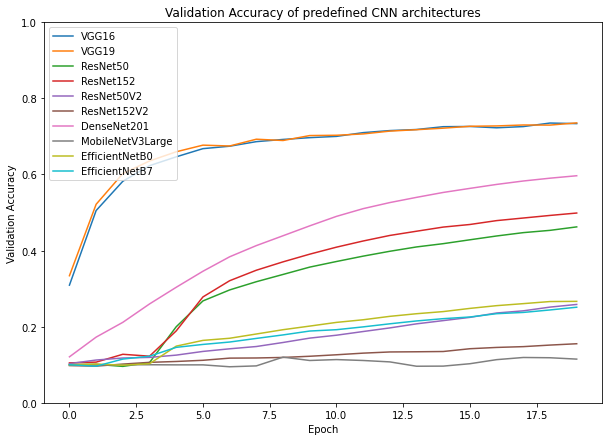

In [5]:
# Display Training Accuracy plot graph
plt.figure(figsize=(10,7))
for history in train_acc:
  plt.plot(history)
plt.title('Training Accuracy of predefined CNN architectures')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.legend(architectures)
plt.ylim(0, 1)
plt.savefig('CNN-architectures-training-accuracy-comparison.jpg', dpi=200)
plt.show()
print()

# Display Validation Accuracy plot graph
plt.figure(figsize=(10,7))
for history in val_acc:
  plt.plot(history)
plt.title('Validation Accuracy of predefined CNN architectures')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(architectures)
plt.ylim(0, 1)
plt.savefig('CNN-architectures-validation-accuracy-comparison.jpg', dpi=200)
plt.show()